In [60]:

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import numpy as np 
import pandas as pd 
import os 

In [100]:
DATASET_PATH = "/home/ec2-user/fashion_data_extracted/fashion-dataset/"
print(os.listdir(DATASET_PATH))


['images.csv', 'images', 'styles.csv', 'styles', 'resized']


In [101]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False)
#df = pd.read_csv("/home/ec2-user/styles.csv", error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch,30039.jpg


In [102]:
import pathlib

data_dir = pathlib.Path('/home/ec2-user/fashion_data_extracted/fashion-dataset/resized/')

In [103]:
image_count = len(list(data_dir.glob('*.*')))
print(image_count)

44441


In [104]:
filter=list(data_dir.glob('*.*'))
filter = [(str(x).split('/')[6]).split('.')[0] for x in filter]


In [105]:
df = df[df["id"].isin(filter)]
len(df)

44441

In [63]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
def img_path(img):
    return DATASET_PATH+"/resized/"+img

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    return img

In [64]:
import matplotlib.pyplot as plt
import numpy as np


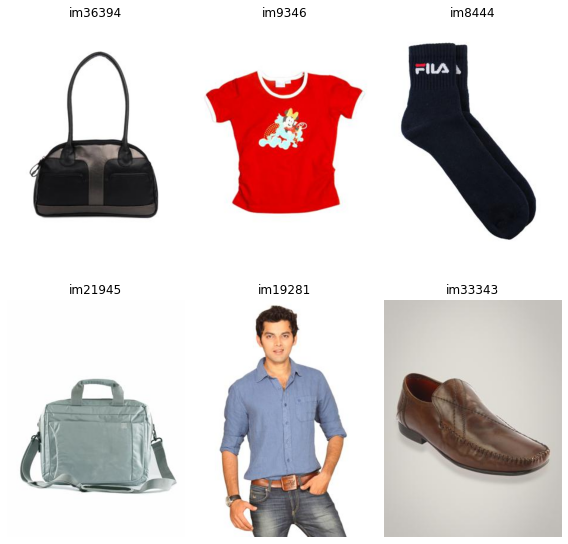

In [65]:
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [66]:
import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D


### Using Pre-Trained ResNet50

In [67]:
img_width, img_height, _ = 300, 400, 3 

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 13, 2048)      23587712  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [84]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 300, 400, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 406, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 200, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 200, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [68]:
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [69]:
emb = get_embedding(model, df.iloc[0].image)
emb.shape

(2048,)

(400, 300, 3)
[ 1.151892  10.582064   0.        ...  0.9544734  2.9821901  7.8529224]


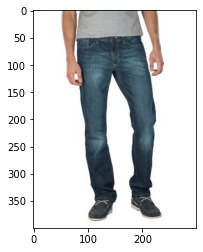

In [70]:
img_array = load_image(df.iloc[1].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [79]:
df_sample['image'].shape

(44446,)

### Embedding the Entire DataSet


In [107]:
df_sample      = df

map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))


df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()




(44441, 2048)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1.151892,10.582064,0.000000,4.655301,1.968098,1.611854,9.069636,10.742418,4.018147,0.132290,...,1.398992,3.160835,0.916297,16.380629,1.251573,0.000000,7.378353,0.954473,2.982190,7.852922
1,5.265217,14.280373,0.000000,7.157317,1.888899,2.673323,11.288797,5.728806,1.329883,1.241097,...,4.415936,1.250834,8.128735,3.848931,0.433849,1.143517,9.321985,0.635867,6.520902,7.802808
2,1.009572,4.045088,1.974870,3.090101,12.370138,4.986764,9.660988,2.106683,3.034616,8.344816,...,2.754571,20.710903,3.924610,10.262600,3.691087,3.031610,14.801587,1.292561,10.083649,12.211498
3,8.352958,10.428374,0.009992,12.491493,2.427379,0.173368,12.971119,4.441759,0.173923,8.132912,...,15.906484,0.000000,4.084682,5.420527,0.000000,0.000000,8.325086,1.274092,5.835989,7.203756
4,3.691510,26.120188,1.521160,5.575885,1.658960,0.000000,7.391940,8.148045,5.442001,0.000000,...,5.359227,6.580582,6.740331,14.923585,0.377746,2.371823,4.048520,1.023078,2.801950,7.428002


### Finding Co Sine Similarities

In [113]:
from sklearn.metrics.pairwise import pairwise_distances
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]



### Recommender Similar Items

In [ ]:
indices = pd.Series(range(len(df)), index=df.index)
indices


def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(2993, df, top_n = 5)

(Int64Index([1389, 634, 3459, 2400, 2970], dtype='int64'),
 [0.9213116, 0.9197278, 0.91948533, 0.9177035, 0.91669774])

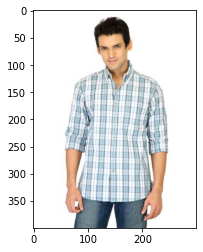

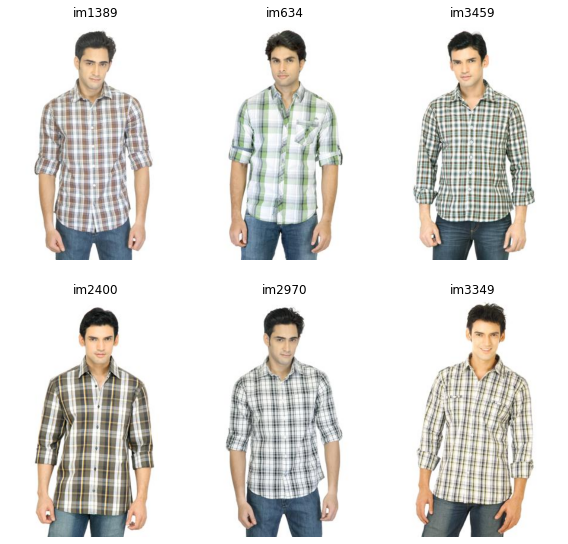

In [112]:
# Idx Item to Recommender
idx_ref = 2993

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)


plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))


figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}

plot_figures(figures, 2, 3)

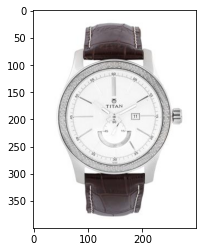

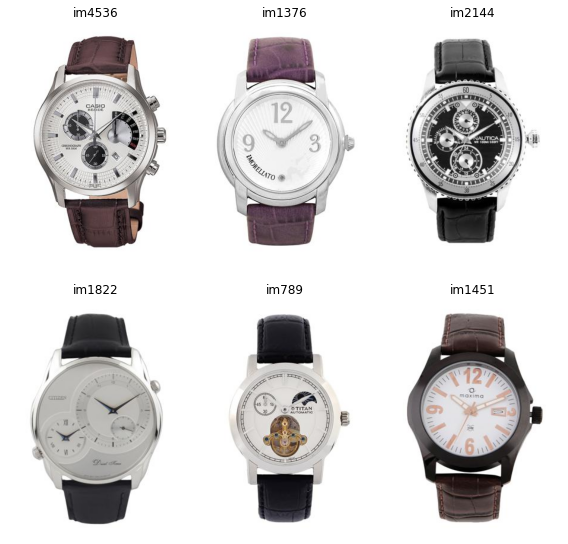

In [ ]:
# Idx Item to Recommender
idx_ref = 2900

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)


plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))


figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}

plot_figures(figures, 2, 3)